In [19]:
import torch
from torch import nn, optim
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('white')
sys.path.insert(0, '../')
#from tta_agg_models import TTARegression, TTAPartialRegression, GPS
from utils.gpu_utils import restrict_GPU_pytorch
import numpy as np
from utils.aug_utils import invert_aug_list
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
restrict_GPU_pytorch('0')
class TTAPartialRegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even',coeffs=[]):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.coeffs = nn.Parameter(torch.randn((n_augs,1 ), requires_grad=True, dtype=torch.float))
        self.temperature = temp_scale
        if len(coeffs):
            self.coeffs = nn.Parameter(torch.Tensor(coeffs), requires_grad=True)
        else:
            if initialization == 'even':
                self.coeffs.data.fill_(1.0/n_augs)
            elif initialization== 'original':
                self.coeffs.data[0,:].fill_(1)
                self.coeffs.data[1,:].fill_(0)

    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = torch.matmul(x.transpose(1, 2), self.coeffs / torch.sum(self.coeffs, axis=0))
        return mult.squeeze()

class TTARegression(nn.Module):
    def __init__(self, n_augs, n_classes, temp_scale=1, initialization='even'):
        super().__init__()
        
        if initialization == 'even':
            self.coeffs = nn.Parameter(torch.randn((n_augs, n_classes), requires_grad=True, dtype=torch.float))
            self.coeffs.data.fill_(1.0/n_augs) 
        else:
            coeffs = torch.cat([torch.Tensor(initialization) for i in range(n_classes)], axis=1)
            self.coeffs = nn.Parameter(coeffs, requires_grad = True)

        self.temperature = temp_scale
    
    def forward(self, x):
        # Computes the outputs / predictions
        x = x/self.temperature
        mult = self.coeffs * x
        return mult.sum(axis=1)
    
#dataset, n_classes = 'imnet', 1000
#dataset, n_classes = 'flowers102', 102
dataset, n_classes = 'cifar100', 100
dataset, n_classes = 'stl10', 10

policy = 'five_crop_hflip_scale'
n_augs = 30
policy = 'hflip_modified_five_crop_scale'
n_augs = 36
agg_models_dir = '../' + dataset + '/' + policy + '/agg_models'
#model_name = 'resnet50'
#model_name = 'cifar100_cnn'
model_name = 'stl10_cnn'

aug_name = 'combo'
aug_model_path = agg_models_dir + '/'+model_name+'/'+aug_name + '/partial_lr.pth'
aug_model = TTAPartialRegression(n_augs,n_classes,1,'even')
aug_model.load_state_dict(torch.load(aug_model_path))
aug_model.eval()
aug_coeffs = aug_model.coeffs.detach().cpu().numpy()

class_model_path = agg_models_dir + '/'+model_name+'/'+aug_name + '/full_lr.pth'
class_model = TTARegression(n_augs,n_classes,1,'even')
class_model.load_state_dict(torch.load(class_model_path))
class_model.eval()
class_coeffs = class_model.coeffs.detach().cpu().numpy()



Using GPU:0


In [17]:
dataset_name_dict = {'birds200': 'Birds200', 'flowers102':'Flowers102', 'imnet':'ImageNet',
                     'cifar100': 'CIFAR100'}

aug_list = np.load('../' + 'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_list.npy')
aug_order = np.load('../' +'flowers102' + '/' + 'five_crop_hflip_scale' + '/aug_order.npy')

aug_list = np.load('../' + dataset + '/' + policy + '/aug_list.npy')
aug_order = np.load('../' + dataset  + '/' + policy + '/aug_order.npy')
aug_names = invert_aug_list(aug_list, aug_order)
[(aug_names[i], coeffs[i][0]) for i in np.where(coeffs > 0)[0]]

[('no hflip,uncropped original,0.0% zoomed in', 0.14551972),
 ('no hflip,upper left crop,4.0% zoomed in', 0.08011005),
 ('no hflip,upper left crop,10.% zoomed in', 0.046758037),
 ('no hflip,lower left crop,0.0% zoomed in', 0.010103556),
 ('no hflip,lower left crop,10.% zoomed in', 0.040788822),
 ('no hflip,lower right,0.0% zoomed in', 0.103559464),
 ('hflip,uncropped original,0.0% zoomed in', 0.2074594),
 ('hflip,upper left crop,0.0% zoomed in', 0.072824396),
 ('hflip,upper left crop,4.0% zoomed in', 0.108944155),
 ('hflip,lower left crop,0.0% zoomed in', 0.059040345)]

In [6]:
results = []
for i in range(len(aug_list)):
    aug_params = aug_list[i]
    coeff = coeffs[i]
    results.append({'coeff': coeff, 'hflip': aug_params[0], 'five_crop': aug_params[1],
                    'scale': aug_params[2]})
results_df = pd.DataFrame(results)

In [12]:
coeffs

array([[0.38282597],
       [0.1808685 ],
       [0.        ],
       [0.        ],
       [0.09189363],
       [0.05544533],
       [0.0880213 ],
       [0.        ],
       [0.        ],
       [0.06371392],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02794123],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.42742383],
       [0.21865381],
       [0.        ],
       [0.        ],
       [0.10828477],
       [0.03349074],
       [0.02005366],
       [0.02174021],
       [0.        ],
       [0.08727674],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [8]:
results_df

,coeff,hflip,five_crop,scale
0,[0.38282597],0.0,5.0,0.00
1,[0.1808685],0.0,5.0,0.04
2,[0.0],0.0,5.0,0.10
3,[0.0],0.0,1.0,0.00
4,[0.09189363],0.0,1.0,0.04
5,[0.05544533],0.0,1.0,0.10
6,[0.0880213],0.0,3.0,0.00
7,[0.0],0.0,3.0,0.04
8,[0.0],0.0,3.0,0.10
9,[0.06371392],0.0,4.0,0.00


Text(0, 0.5, '')

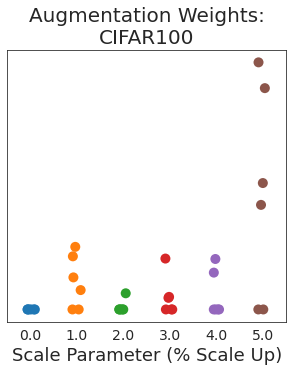

In [10]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(5, 5))
ax = sns.stripplot(x='five_crop', y='coeff', data=results_df, size=10)
plt.title("Augmentation Weights:\n" + dataset_name_dict[dataset] )
plt.ylabel("Augmentation Weight")
plt.xlabel("Scale Parameter (% Scale Up)")
#ax.set_xticklabels(['0.0', '4.0', '10.0'])
#plt.ylim(-.01, .11)
ax.set_yticklabels([])
ax.set_ylabel("")
#plt.tight_layout()

In [57]:
coeffs

array([[0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.04704392],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.02798502],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00645093],
       [0.00645093],
       [0.00645093],
       [0.00645093],
       [0.00645093],
       [0.00645093],
       [0.00645093],
       [0.006